<a href="https://colab.research.google.com/github/smlra-kjsce/PyTorch-101/blob/main/Neural_networks_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
#@title Installing Pyorch

!pip install torch
!pip install torchvision


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd`` to define models and differentiate them along with ``nn``.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

For example, look at this network that classifies digit images:

.. figure:: /_static/img/mnist.png
   :alt: convnet

   convnet

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 1. The convolution step
<figure>
<center>


<figure>
<center>
<img src='https://drive.google.com/uc?id=1QumoiRuwx-g4N-F4vLOyOUDWqt9OsxWP'/>
  </center>
  <center><figcaption><b>Some common filters</b></figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?id=17Bk_CnB1VjimpkWP7q9tZKqQ-lK8XJun'/>
  </center>
  <center><figcaption><b>Generation of feature maps</b></figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?id=1Te-E_r68MH6A_QGBDGLx1scADZ2_RfKz'/>
  </center>
  <center><figcaption><b>Stack of feature maps</b></figcaption></center>
</figure>

## 3. Pooling or Sub Sampling

Spatial Pooling (also called subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum etc.


```
# This is formatted as code
```


In case of Max Pooling, we define a spatial neighborhood (for example, a 2×2 window) and take the largest element from the rectified feature map within that window. Instead of taking the largest element we could also take the average (Average Pooling) or sum of all elements in that window. In practice, Max Pooling has been shown to work better.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1qZ7BIOC3VVt-4HVvpG0PJXTNdoLRY84g'/>
  </center>
  <center><figcaption><b>How max pooling works</b></figcaption></center>
</figure>

We slide our 2 x 2 window by 2 cells (also called ‘stride’) and take the maximum value in each region. This reduces the dimensionality of our feature map.

In the network shown below, pooling operation is applied separately to each feature map (notice that, due to this, we get three output maps from three input maps).

<figure>
<center>
<img src='https://drive.google.com/uc?id=1c1PLdRPkIeqFXZWytUDJpQX-uPcMUEVg'/>
  </center>
  <center><figcaption><b>Stack of pooled layers</b></figcaption></center>
</figure>

The function of Pooling is to progressively reduce the spatial size of the input representation. In particular, pooling:
1. makes the input representations (feature dimension) smaller and more manageable 
2. reduces the number of parameters and computations in the network, therefore, controlling overfitting 
3. makes the network invariant to small transformations, distortions and translations in the input image (a small distortion in input will not change the output of Pooling – since we take the maximum / average value in a local neighborhood).
4. helps us arrive at an almost scale invariant representation of our image (the exact term is “equivariant”). This is very powerful since we can detect objects in an image no matter where they are located.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1teXgbRKEY--9JfmbInHyeDXMVpQR0iks'/>
  </center>
  <center><figcaption><b>Result of pooling</b></figcaption></center>
</figure>

You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight
print(params[0]) 

10
torch.Size([6, 1, 3, 3])
Parameter containing:
tensor([[[[ 0.0474,  0.0946, -0.0675],
          [ 0.2038, -0.0255, -0.0489],
          [ 0.0351,  0.0783,  0.1563]]],


        [[[-0.0352, -0.1122,  0.2820],
          [ 0.1492,  0.2132,  0.2717],
          [ 0.0182,  0.1383, -0.0215]]],


        [[[ 0.3038,  0.1818, -0.2401],
          [-0.2929,  0.2214,  0.1073],
          [ 0.2686, -0.3297, -0.1090]]],


        [[[-0.3045,  0.0959, -0.1403],
          [ 0.0825, -0.0408,  0.3136],
          [-0.2863, -0.2857, -0.0604]]],


        [[[-0.3324,  0.0296, -0.1600],
          [ 0.1382,  0.1299,  0.0634],
          [ 0.1363,  0.1455,  0.2431]]],


        [[[ 0.2499, -0.0742, -0.1872],
          [-0.1841, -0.2174, -0.2788],
          [ 0.0447,  0.1743, -0.2125]]]], requires_grad=True)


Let's try a random 32x32 input.
Note: expected input size of this net (LeNet) is 32x32. To use this net on
the MNIST dataset, please resize the images from the dataset to 32x32.



In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0099,  0.1326, -0.0589,  0.0098, -0.1018, -0.0244,  0.0434,  0.0134,
         -0.0312,  0.0175]], grad_fn=<AddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random

> Indented block


gradients:



In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.
     Autograd is a PyTorch package for the differentiation for all operations on Tensors. It performs the backpropagation starting from a variable. In deep learning, this variable often holds the value of the cost function. backward executes the backward pass and computes all the backpropagation gradients automatically. We access indvidual gradient through the attributes grad of a variable.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <https://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [7]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.5426, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [8]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [9]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0011, -0.0039,  0.0121,  0.0005, -0.0022,  0.0077])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is `here <https://pytorch.org/docs/nn>`_.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple Python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [10]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in the `Backprop`_ section.



Let's Revise the concepts with an example

In [11]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [12]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step 

In [13]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [15]:
#@title Define model class

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [16]:
#@title Build the model

net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [17]:
#@title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [18]:
#@title Training the model
cost=[]
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images.view(-1,28*28)).cuda()
    labels = Variable(labels).cuda()
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
      cost.append(loss.data.cpu().numpy())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data))

Epoch [1/20], Step [100/600], Loss: 0.2689
Epoch [1/20], Step [200/600], Loss: 0.2178
Epoch [1/20], Step [300/600], Loss: 0.2176
Epoch [1/20], Step [400/600], Loss: 0.3366
Epoch [1/20], Step [500/600], Loss: 0.2319
Epoch [1/20], Step [600/600], Loss: 0.1570
Epoch [2/20], Step [100/600], Loss: 0.0936
Epoch [2/20], Step [200/600], Loss: 0.0773
Epoch [2/20], Step [300/600], Loss: 0.1080
Epoch [2/20], Step [400/600], Loss: 0.1589
Epoch [2/20], Step [500/600], Loss: 0.1089
Epoch [2/20], Step [600/600], Loss: 0.0408
Epoch [3/20], Step [100/600], Loss: 0.0843
Epoch [3/20], Step [200/600], Loss: 0.0535
Epoch [3/20], Step [300/600], Loss: 0.0315
Epoch [3/20], Step [400/600], Loss: 0.0239
Epoch [3/20], Step [500/600], Loss: 0.0237
Epoch [3/20], Step [600/600], Loss: 0.0759
Epoch [4/20], Step [100/600], Loss: 0.0569
Epoch [4/20], Step [200/600], Loss: 0.1595
Epoch [4/20], Step [300/600], Loss: 0.0492
Epoch [4/20], Step [400/600], Loss: 0.0381
Epoch [4/20], Step [500/600], Loss: 0.0537
Epoch [4/20

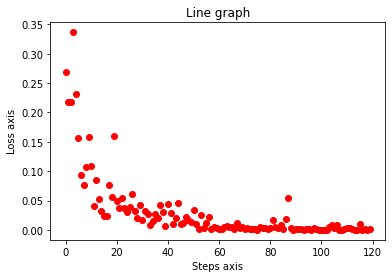

In [19]:
import numpy as np  
import matplotlib.pyplot as plt  

x=range(6*20)
# plotting 
plt.title("Line graph")  
plt.xlabel("Steps axis")  
plt.ylabel("Loss axis")  
plt.scatter(x, cost, color ="red")  
plt.show()

In [20]:
#@title Evaluating the accuracy of the model

correct = 0
total = 0
for images,labels in test_gen:
  images = Variable(images.view(-1,28*28)).cuda()
  labels = labels.cuda()
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

Accuracy of the model: 98.030 %
